## Imports

In [1]:
import os
import pickle
import json
from PIL import Image
import random
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import math
import pprint
import requests
import torch
import pandas
import torchvision

from io import BytesIO
from torchvision import transforms
from typing import List
from traitlets.config.loader import ArgumentError

%matplotlib inline

In [2]:
from clip import clip

## Dataset
Handle the dataset RefCocoG

In [3]:
root=  "E:/DL_Datasets/refcocog"
def display_dataset_entry_with_category(d, categories):
  #pprint.pprint(d)

  index=0
  
  #pprint.pprint(str(d))
  plt.figure(figsize=(16, 5))
  plt.tight_layout()
  for r in d['references']: 
    img = Image.open(os.path.join(root,"images/", d["image"]["file_name"]))
    img = np.asarray(img)
    # build bounding boxes
    bbox = r["annotation"]['bbox']
    bbox = [int(i) for i in bbox]

    p1 = (bbox[0], bbox[1])
    p2 = (bbox[0]+bbox[2], bbox[1]+bbox[3])
    color = (0,255,0)
    thickness =3
    cv2.rectangle(img, p1, p2, color, thickness)
    # end of build bounding boxes

    # build segmentation
    # thickness = 3
    # for s in ann['segmentation']:
    #   segmentation = [int(i) for i in s]
    #   radius = 1
    #   color = (random.randint(0,255), random.randint(0,255),random.randint(0,255))
    #   for i in range(0, len(segmentation), 2):
    #     p1 = segmentation[i]
    #     p2 = segmentation[i+1]

    #     if (i + 2 == len(segmentation)):
    #       p3 = segmentation[0]
    #       p4 = segmentation[1]
    #     else:
    #       p3 = segmentation[i+2]
    #       p4 = segmentation[i+3]

    #     cv2.line(img, (p1, p2), (p3, p4), color, thickness)
    # end of build segmentation

    category_id = r["annotation"]['category_id']
    text = ""
    for s in r["sentences"]:
      text += s["sent"]+"\n"

    plt.subplot(2,math.ceil(len(d['references'])/2), index+1)
    plt.imshow(img)
    plt.title(text,fontsize = 8)
    plt.xticks([])
    plt.yticks([])
    index +=1
  
  plt.tight_layout()
  plt.show()
  print("-"*50)


In [4]:
def load_dataset(pick, jsn)->any:
  data = []
  annotationsDict = {}
  sentencesDict ={}
  print("building sentences dict")
  for i in range(len(pick)):
      p = pick[i]
      #pprint.pprint(p)
      # map ={} if sentencesDict[p["image_id"]] is None else sentencesDict[p["image_id"]] 
      # map[p["ann_id"]]={"value":p["sentences"]}
      # print(map)
      if p["image_id"] in sentencesDict:
        sentencesDict[p["image_id"]].append({"ann_id":p["ann_id"],"sentences":p["sentences"]})
      else:
        sentencesDict[p["image_id"]] = [{"ann_id":p["ann_id"],"sentences":p["sentences"]}]
      #pprint.pprint(sentencesDict)
      # if p["image_id"] in sentencesDict:
      #   sentencesDict[p["image_id"]][p["ann_id"]]={"value":p["sentences"]}
      # else:
      #   sentencesDict[p["image_id"]]=[{"value":p["sentences"], "sent_ids":p["sent_ids"]}]

  print("building annotations dict")

  for a in jsn["annotations"]:
    #pprint.pprint(a)
    if a["image_id"] not in sentencesDict: continue
    elem = None
    for x in sentencesDict[a["image_id"]]:
      # pprint.pprint(x)
      # print("\n\n")
      if x["ann_id"] == a["id"]:
        elem = x
    if elem is None:continue
    sentencesDict[a["image_id"]].remove(elem)
    sentencesDict[a["image_id"]].append({"sentences":elem["sentences"], "annotation":a, "ann_id": a["id"]})
    # sentencesDict[a["image_id"]] [a["id"]] ["annotation"]=a
    # if a["image_id"] in sentencesDict:
    #   sentencesDict[a["image_id"]][a["id"]["annotation"]]=a
    # else:
    #   annotationsDict[a["image_id"]] = [a]


  print("building dataset")
  for img in jsn["images"]:
    if img["id"] not in sentencesDict: continue
    elem = {}
    elem["image"]=img
    #elem["annotations"]= annotationsDict[img["id"]]
    elem["references"] = sentencesDict[img["id"]]
    data.append(elem)

  print("dataset length: "+str(len(data)))

  print("building categories")
  categories = {}
  for category in jsn["categories"]:
    cat_id = category["id"]
    categories[cat_id] = category

  return data, categories

# Model template

This is a possible advanced model blueprint that we could use.
It uses the CLIP encodings for both `text` and `images`.

In [5]:
class DLModel(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # Load the CLIP backbone
    self.clip_model, self.preprocess = clip.load("RN50")

    # It is possible here to add whatever we want, like sequentals and attention based layers.
    # In theory this layer should have the job to weight the CLIP's encoding of the text to weight more the important keywords.
    # For this reason it should be advisable to use an LSTM with attention mechanism, having the correct number of inputs and outputs.
    # At the moment just use a linear bottleneck
    features=1024

    self.text_mlp = torch.nn.Sequential(
        torch.nn.Linear(features, features),
        torch.nn.BatchNorm1d(features),
        torch.nn.Tanh(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(features, features),
        torch.nn.BatchNorm1d(features),
        torch.nn.Tanh())
    self.text_mlp.apply(self.weights_init)

    # This layer should extract the bounding box having inputs from ResNet50 and the CLIP encodings of both text and image.
    # The return dimension can vary depending on what we want. For now I recognized that in the dataset,
    # each annotation has only one bounding box, therefore returning a single bounding box should be fine
    # BBoxes can be returned from four points in the domain [0, 1] : [top_left, top_right, bottom_left, bottom_right].
    self.boxer = torch.nn.Sequential(
        torch.nn.Linear(features, features//2),
        torch.nn.BatchNorm1d(features//2),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(features//2, features//8),
        torch.nn.BatchNorm1d(features//8),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(features//8, features//16),
        torch.nn.BatchNorm1d(features//16),
        torch.nn.Sigmoid(),      
        torch.nn.Linear(features//16, 4),
        torch.nn.Sigmoid())

    self.boxer.apply(self.weights_init)

  def optim_params(self):
    return list(self.boxer.parameters()) + list(self.text_mlp.parameters())
  
  def weights_init(self, m):
      if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0,  1)
      if isinstance(m, torch.nn.BatchNorm1d):
        torch.nn.init.normal_(m.weight, 0.0, 1)

  def encode(self, images, prompts,device="cuda:0")->List[torch.Tensor]:
    """
    Encode data into Tensors in a friendly way from images and prompts
    """
    if len(images) != len(prompts):
      raise ArgumentError("Images and prompts are of different length!")
    images = [self.preprocess(img) for img in images]
    images = torch.tensor(np.stack(images)).to(device)
    prompts = clip.tokenize([p for p in prompts]).to(device)
    return [images, prompts]

  def forward(self, src: List[torch.tensor]) -> torch.tensor:
      # Check size
      if src[0].shape[0] != src[1].shape[0]:
        raise ArgumentError("Images and prompts are of different length!")

      # Encode text and image with CLIP
      txt = self.clip_model.encode_text(src[1]).float()
      txt = self.text_mlp(txt)
      vis = self.clip_model.encode_image(src[0]).float()

      # Concatenate tensors
      src =txt.add(vis)/2# torch.cat((txt,vis), -1)
      src = self.boxer(src)
      return src

# Transformer Model

In [6]:
class DLTransformer(torch.nn.Module):
    def __init__(self, n_heads:int=4, encoder_layers:int=3):
        super().__init__()
        
        # if 1024%n_heads!=0:
        #   raise ArgumentError("Number of heads must be a dividend of 2048")

        self.n_heads=n_heads
        self.clip_model, self.preprocess = clip.load("RN50")
        self.feature_size=1024
        self.transformer_model = torch.nn.Transformer(d_model=self.feature_size, nhead=n_heads, num_encoder_layers=encoder_layers,batch_first=True)
        self.boxer = torch.nn.Sequential(
          torch.nn.Linear(self.feature_size, self.feature_size//2),
          torch.nn.BatchNorm1d(self.feature_size//2),
          torch.nn.Sigmoid(),
          torch.nn.Dropout(p=0.1),
          torch.nn.Linear(self.feature_size//2, self.feature_size//8),
          torch.nn.BatchNorm1d(self.feature_size//8),
          torch.nn.Sigmoid(),
          torch.nn.Dropout(p=0.1),
          torch.nn.Linear(self.feature_size//8, self.feature_size//16),
          torch.nn.BatchNorm1d(self.feature_size//16),
          torch.nn.Sigmoid(),      
          torch.nn.Linear(self.feature_size//16, 4),
          torch.nn.Sigmoid())
        
        self.transformer_model.apply(self.weights_init)
        self.boxer.apply(self.weights_init)

    def optim_params(self):
        return list(self.boxer.parameters()) + list(self.transformer_model.parameters())
    
    def weights_init(self, m):
        if isinstance(m, torch.nn.Linear):
          torch.nn.init.normal_(m.weight, 0.0,  0.75)
        if isinstance(m, torch.nn.BatchNorm1d):
          torch.nn.init.normal_(m.weight, 0.0, 0.75)

    def encode(self, images:List, prompts:List)->List[torch.tensor]:
        """
        Encode data into Tensors in a friendly way from images and prompts
        """
        if len(images) != len(prompts):
          raise ArgumentError("Images and prompts are of different length!")
          return
        device = next(self.parameters()).device
        images = [self.preprocess(img) for img in images]
        images = torch.tensor(np.stack(images)).to(device)
        prompts = clip.tokenize([p for p in prompts]).to(device)
        return [images, prompts]

    def forward(self, src: List[torch.tensor]) -> torch.tensor:
        # Check size
        if src[0].shape[0] != src[1].shape[0]:
          raise ArgumentError("Images and prompts are of different length!")
          return

        # Encode text and image with CLIP, [n, 1024]
        vis = self.clip_model.encode_image(src[0]).float()
        txt = self.clip_model.encode_text(src[1]).float()

        # Concatenate tensors [n, 2048]
        #src = torch.cat((txt, vis), -1)
        src=txt.add(vis)/2
        # Reshape tensor as sequence [n, n_head, 2048/n_head]
        #batch_size = src.shape[0]
        #src = src.reshape(batch_size, self.n_heads, self.feature_size)
        
        # Positional encode for the transformer [n, n_head, 2048/n_head]
        #src = self.pos_encoder(src)
        #print(src.size())
        # Create transformer's mask
        #transformer_mask = torch.triu(torch.ones(self.n_heads, self.n_heads) * float('-inf'), diagonal=1).to(next(self.parameters()).device)
        #src = src.reshape(batch_size, self.n_heads, self.feature_size)
        # Transformer's encoder pass [n, n_head, 2048/n_head]
        #src = self.transformer_encoder(src)
        
        #txt = self.query_linear(txt)
        #src =  self.transformer_model(txt, src)
        #src = src.reshape(batch_size, self.n_heads, self.feature_size)
        #src = src.reshape(batch_size, 2048)
        #txt = self.text_projector(txt)# txt.reshape(batch_size, self.n_heads//2, self.feature_size)
        src = self.transformer_model(txt, src)
        #print(src.size())
        # Reshape tensor [n, 2048]
        #src = src.reshape(batch_size, 1024)
        # MLP pass 
        src = self.boxer(src)
        return src


# Training

### Loss

In [7]:
class GroundingLoss(torch.nn.Module):
  def __init__(self, reduction="mean"):
    super().__init__()
    self.reduction = reduction
    self.loss = torch.nn.MSELoss(reduction=reduction)

  def forward(self, input:torch.tensor, target:torch.tensor):
    giou=self.giou_loss(input, target,reduction=self.reduction)
    mse_loss = self.loss(input, target)
    return mse_loss

  def giou_loss(self,
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "sum",
    eps: float = 1e-7,
  ) -> torch.Tensor:
      x1, y1, w, h = boxes1.unbind(dim=-1)
      x2 = x1+w
      y2 = y1+h
      x1g, y1g, wg, hg = boxes2.unbind(dim=-1)
      x2g = x1g+wg
      y2g = y1g+hg
      #print([x1,y1,x2,y2])
      #print([x1g,y1g,x2g,y2g])

      assert (x2 >= x1).all(), "bad box: x1 larger than x2"
      assert (y2 >= y1).all(), "bad box: y1 larger than y2"

      # Intersection keypoints
      xkis1 = torch.max(x1, x1g)
      ykis1 = torch.max(y1, y1g)
      xkis2 = torch.min(x2, x2g)
      ykis2 = torch.min(y2, y2g)

      intsctk = torch.zeros_like(x1)
      mask = (ykis2 > ykis1) & (xkis2 > xkis1)
      intsctk[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
      unionk = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsctk
      iouk = intsctk / (unionk + eps)

      # smallest enclosing box
      xc1 = torch.min(x1, x1g)
      yc1 = torch.min(y1, y1g)
      xc2 = torch.max(x2, x2g)
      yc2 = torch.max(y2, y2g)

      area_c = (xc2 - xc1) * (yc2 - yc1)
      miouk = iouk - ((area_c - unionk) / (area_c + eps))

      loss = 1 - miouk

      if reduction == "mean":
          loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
      elif reduction == "sum":
          loss = loss.sum()

      return loss

### Build Training Data

In [8]:
from torch import nn
import torch.optim as optim

def load_training_data(refcocog):
  images_train = []
  prompts_train = []
  bboxes = []

  for d in refcocog:
    for ref in d['references']:
      for sentence in ref['sentences']:
        if 'annotation' in ref:
          images_train.append(os.path.join(root,"images/", d["image"]["file_name"]))
          prompts_train.append(sentence['raw'])          
          bbox = ref['annotation']['bbox']        
          bboxes.append(bbox)
  return [images_train, prompts_train, bboxes]

def train_model(dataset, model, epochs:int = 10, batch_size:int=16, train_data_size:int=None,device="cuda:0", normalized_bbox=True):
  images_train, prompts_train, bboxes = dataset
  
  print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters() if p.requires_grad]):,}")

  loss_criterion = GroundingLoss()
  clip_params = []
  params = []
  for name, param in model.named_parameters():    
    if name.startswith('clip_model'):
      clip_params.append(param)
    else:
      params.append(param)
      print(name)


  #optimizer = optim.SGD(model.optim_params(),lr=2e-3)
  optimizer = optim.Adam(model.optim_params(),lr=1e-3)
  #optimizer = optim.Adagrad(model.optim_params(),lr=1e-3)
  # optimizer = optim.Adam([
  #     {"params": model.clip_model.parameters(), "lr": 0.00001},
  #     {"params": model.parameters(),"lr":0.00005}
  # ], lr=0.00005)

  model.train()

  if train_data_size is None: 
    train_data_size = len(images_train) // 16

  for k in range(epochs):
    epoch_loss=0
    index = 0
    print("epoch", k)
    for i in range(0, train_data_size, batch_size):
      images=[]
      boxes=[]
      prompts=[]
      range_end=min(i+batch_size, len(images_train))
      #print("range end: "+str(range_end)+", i: "+str(i))
      for j in range(i, range_end):
        img = Image.open(images_train[j])
        images.append(img)
        prompts.append(prompts_train[j])

        if normalized_bbox:
          boxes.append([bboxes[j][0]/img.width,bboxes[j][1]/img.height, bboxes[j][2]/img.width,bboxes[j][3]/img.height])
        else:
          boxes.append(bboxes)

      optimizer.zero_grad()
      output=model(model.encode(images, prompts))
      c_b=torch.tensor(boxes).to(device)      
      #print(c_b[:,:2].reshape(c_b.size()[0], 2))
      #print(output)
      # TODO change, training only on the x
      #loss=loss_criterion(output,c_b[:,:2])
      loss=loss_criterion(output,c_b)
      #print(loss)
      epoch_loss+=loss.item()
      index+=1
      loss.backward()
      optimizer.step()

      # if (i % (batch_size*4) == 0):
      #   print(i, loss)  
    epoch_loss/=(index)
    print("epoch "+ str(k)+", average loss per batch: "+str(epoch_loss))
  #len(images_train), len(prompts_train), len(bboxes)

### Evaluate

In [16]:
def eval_inference(dataset, model, num_inference:int =4, normalized_bbox=True, show_bbox=True):
  %matplotlib inline
  images_train, prompts_train, bboxes = dataset
  model.eval()
  loss = GroundingLoss()
  for i in range(num_inference):
    index = random.randint(0,len(images_train)-1)
    img = Image.open(images_train[index])
    prm =  prompts_train[index]
    bbox = bboxes[index]
    tensors = model.encode([img], [prm])
    width = img.width
    height = img.height

    if normalized_bbox:
      normalized_b = [bbox[0]/width, bbox[1]/height, bbox[2]/width, bbox[3]/height]
    else:
      normalized_b = bbox

    with torch.no_grad():
      output = model.forward(tensors).to("cpu")
      output = output[0].detach().numpy()
      print("correct: "+str(normalized_b))
      print("inferred: "+str(list(output)))
      if show_bbox:
        if normalized_bbox:
          p1 = (int(output[0]*width), int(output[1]*height))
          p2 = (int((output[0]+output[2])*width), int((output[1]+output[3])*height))
        else:
          p1 = (output[0], output[1])
          p2 = (output[0] + output[2], output[1] + output[3])
        color = (0,255,255)
        thickness = 3
        img = np.asarray(img)
        cv2.rectangle(img, p1, p2, color, thickness)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int((bbox[0]+bbox[2])), int((bbox[1]+bbox[3]))), (0,255,0), thickness)
    print("Element: "+str(index))

    print("Loss: "+  str(loss(torch.tensor(output), torch.tensor(normalized_b))))
    print(prm)
    plt.imshow(img)
    plt.show()
    print("-"*100)

### Dataset

In [10]:
print("loading pickle")
pick = pickle.load(open(os.path.join(root,"annotations","refs(google).p"), "rb"))
print("loading json")
jsn = json.load(open(os.path.join(root,"annotations","instances.json"), "rb"))
print("loading dataset")
refcocog, categories = load_dataset(pick, jsn)
print("loading training data")
images_train, prompts_train, bboxes = load_training_data(refcocog)
print(len(images_train))

loading pickle
loading json
loading dataset
building sentences dict
building annotations dict
building dataset
dataset length: 25799
building categories
loading training data
95007


### Normal Model

In [11]:
model = DLModel()
model = model.to("cuda:0")

In [ ]:
train_model([images_train, prompts_train, bboxes], model, train_data_size=2**12, batch_size=32,epochs=1024)

In [165]:
# Just an example, repeating image
img_path = ["https://cdn.pixabay.com/photo/2015/04/23/22/00/tree-736885_1280.jpg"]*3;
images = [Image.open(BytesIO(requests.get(p).content)) for p in img_path]
prompts = ["another extra evva prompt","another cool prompt","final prompt"]

tensors = model.encode(images, prompts, device="cuda:0")
with torch.no_grad():
  output = model.forward(tensors)

print(output)
print(output.size())

tensor([[0.2536, 0.0826, 0.6771, 0.5300],
        [0.2240, 0.1004, 0.2291, 0.8313],
        [0.3256, 0.7180, 0.3448, 0.1877]], device='cuda:0')
torch.Size([3, 4])


In [ ]:
img_path = "https://www.nieddittas.it/wp-content/uploads/2022/06/come-scegliere-l-ombrellone-da-spiaggia.jpg"
prompts = ["the orange umbrella in the middle","the red closed umbrella on the leftmost side","red closed umbrella"]
images = [Image.open(BytesIO(requests.get(img_path).content)) for p in range(len(prompts))]

tensors = model.encode(images, prompts)

with torch.no_grad():
  output = model.forward(tensors)

print(output)
%matplotlib inline
for i,o in enumerate(output):
  img = images[i]
  width = images[i].width
  height = images[i].height
  p1 = (int(o[0]*width), int(o[1]*height))
  p2 = (int((o[0]+o[2])*width), int((o[1]+o[3])*height))
  color = (0,255,255)
  thickness = 3
  img = np.asarray(img)
  cv2.rectangle(img, p1, p2, color, thickness)
  print(prompts[i])
  plt.imshow(img)
  plt.show()

In [15]:
torch.save(model.state_dict(), "mid_checkpoint")

correct: [0.03896875, 0.15585416666666668, 0.488953125, 0.64675]
inferred: [0.09307201, 0.15495218, 0.4423296, 0.3181256]
Element: 34027
Loss: tensor(0.0283)
red plate with banana


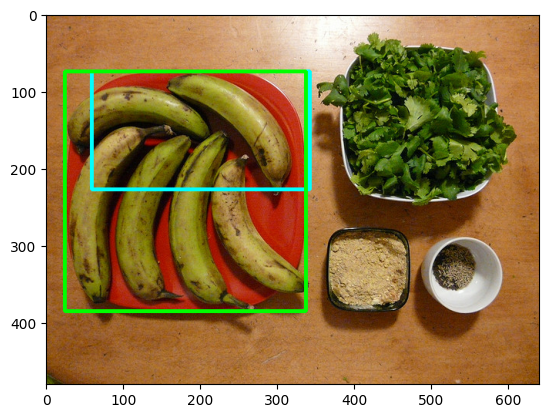

----------------------------------------------------------------------------------------------------
correct: [0.351421875, 0.12007042253521126, 0.564375, 0.8680046948356807]
inferred: [0.51480377, 0.17949864, 0.32867, 0.60618085]
Element: 81075
Loss: tensor(0.0386)
the man standing up


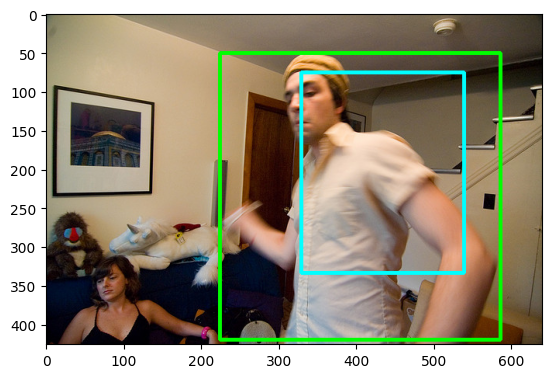

----------------------------------------------------------------------------------------------------
correct: [0.38896, 0.1544, 0.20226, 0.7694666666666667]
inferred: [0.4767271, 0.20420824, 0.23257494, 0.5498141]
Element: 12133
Loss: tensor(0.0148)
Player in the red shorts


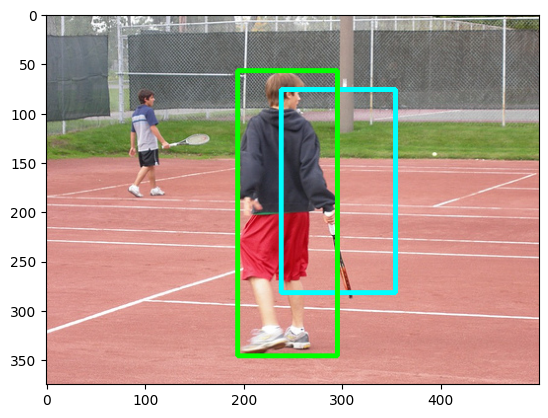

----------------------------------------------------------------------------------------------------
correct: [0.005796344647519582, 0.683171875, 0.5533420365535249, 0.254640625]
inferred: [0.45212656, 0.20640244, 0.44573557, 0.19575852]
Element: 89004
Loss: tensor(0.1104)
the plate of meet


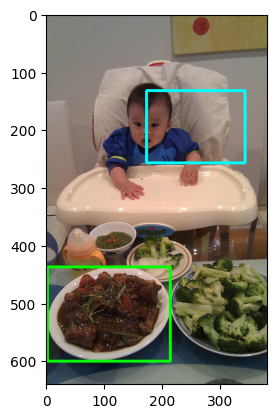

----------------------------------------------------------------------------------------------------


In [20]:
eval_inference([images_train, prompts_train, bboxes], model,num_inference=2**2, show_bbox=True)

In [159]:
loss = nn.MSELoss(reduction="none")
input = torch.as_tensor([[0.25,0.25,0.2,0.2],[0.25,0.25,0.2,0.2]])
input.requires_grad_()
target =torch.as_tensor([[0.2,0.2,0.25,0.25],[0.2,0.2,0.25,0.25]])
print(input)
print(target)
b = GroundingLoss().giou_loss(input, target, reduction="none")
output = loss(input, target)
print(b)
print(output)

tensor([[0.2500, 0.2500, 0.2000, 0.2000],
        [0.2500, 0.2500, 0.2000, 0.2000]], requires_grad=True)
tensor([[0.2000, 0.2000, 0.2500, 0.2500],
        [0.2000, 0.2000, 0.2500, 0.2500]])
tensor([0.3600, 0.3600], grad_fn=<RsubBackward1>)
tensor([[0.0025, 0.0025, 0.0025, 0.0025],
        [0.0025, 0.0025, 0.0025, 0.0025]], grad_fn=<MseLossBackward0>)


### Transformer

In [148]:
model = DLTransformer()
model = model.to("cuda:0")
#model = model.to("cpu")

In [149]:
train_model([images_train, prompts_train, bboxes], model, train_data_size=2**4, batch_size=2,epochs=128)

Model parameters: 203,413,157
transformer_model.encoder.layers.0.self_attn.in_proj_weight
transformer_model.encoder.layers.0.self_attn.in_proj_bias
transformer_model.encoder.layers.0.self_attn.out_proj.weight
transformer_model.encoder.layers.0.self_attn.out_proj.bias
transformer_model.encoder.layers.0.linear1.weight
transformer_model.encoder.layers.0.linear1.bias
transformer_model.encoder.layers.0.linear2.weight
transformer_model.encoder.layers.0.linear2.bias
transformer_model.encoder.layers.0.norm1.weight
transformer_model.encoder.layers.0.norm1.bias
transformer_model.encoder.layers.0.norm2.weight
transformer_model.encoder.layers.0.norm2.bias
transformer_model.encoder.layers.1.self_attn.in_proj_weight
transformer_model.encoder.layers.1.self_attn.in_proj_bias
transformer_model.encoder.layers.1.self_attn.out_proj.weight
transformer_model.encoder.layers.1.self_attn.out_proj.bias
transformer_model.encoder.layers.1.linear1.weight
transformer_model.encoder.layers.1.linear1.bias
transformer_

In [ ]:
eval_inference([images_train, prompts_train, bboxes], model,num_inference=8, show_bbox=True)

tensor([[0.3283, 0.4196, 0.5662, 0.4125],
        [0.4254, 0.4402, 0.3169, 0.3169],
        [0.4366, 0.2592, 0.3669, 0.3443]], device='cuda:0')
umbrella


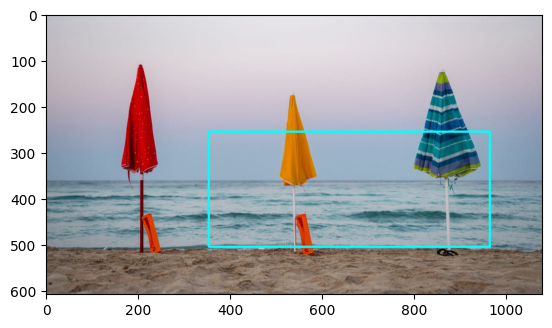

closed umbrella


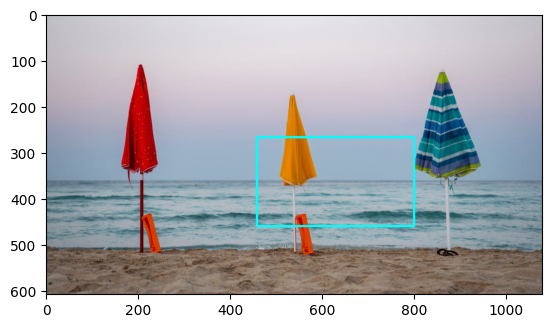

red closed umbrella


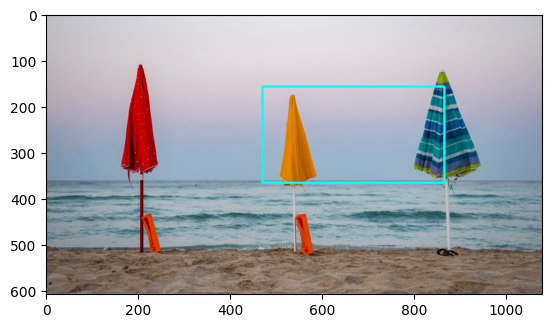

In [78]:
img_path = "https://www.nieddittas.it/wp-content/uploads/2022/06/come-scegliere-l-ombrellone-da-spiaggia.jpg"
prompts = ["umbrella","closed umbrella","red closed umbrella"]
images = [Image.open(BytesIO(requests.get(img_path).content)) for p in range(len(prompts))]

tensors = model.encode(images, prompts)

with torch.no_grad():
  output = model.forward(tensors)

print(output)
%matplotlib inline
for i,o in enumerate(output):
  img = images[i]
  width = images[i].width
  height = images[i].height
  p1 = (int(o[0]*width), int(o[1]*height))
  p2 = (int((o[0]+o[2])*width), int((o[1]+o[3])*height))
  color = (0,255,255)
  thickness = 3
  img = np.asarray(img)
  cv2.rectangle(img, p1, p2, color, thickness)
  print(prompts[i])
  plt.imshow(img)
  plt.show()



In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

211